In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()
Pkg.add("LinearAlgebra")
Pkg.add("ForwardDiff")
Pkg.add("PyPlot")

  Activating project at `~/Projects/learning/lecture-notebooks/Lecture 6`
┌ Warning: The active manifest file is an older format with no julia version entry. Dependencies may have been resolved with a different julia version.
└ @ ~/Projects/learning/lecture-notebooks/Lecture 6/Manifest.toml:0
   Resolving package versions...
┌ Warning: The active manifest file at `/home/xinyu/Projects/learning/lecture-notebooks/Lecture 6/Manifest.toml` has an old format that is being maintained.
│ To update to the new format, which is supported by Julia versions ≥ 1.6.2, run `import Pkg; Pkg.upgrade_manifest()` which will upgrade the format without re-resolving.
│ To then record the julia version re-resolve with `Pkg.resolve()` and if there are resolve conflicts consider `Pkg.update()`.
└ @ Pkg.Types ~/.julia/juliaup/julia-1.10.0+0.x64.linux.gnu/share/julia/stdlib/v1.10/Pkg/src/manifest.jl:318
  No Changes to `~/Projects/learning/lecture-notebooks/Lecture 6/Project.toml`
  No Changes to `~/Projects/lea

In [2]:
using LinearAlgebra
using ForwardDiff
using PyPlot

In [3]:
Q = Diagonal([0.5; 1])
function f(x)
    return 0.5*(x-[1; 0])'*Q*(x-[1; 0])
end
function ∇f(x)
    return Q*(x-[1; 0])
end
function ∇2f(x)
    return Q
end

∇2f (generic function with 1 method)

In [4]:
function c(x)
    return x[1]^2 + 2*x[1] - x[2]
end
function ∂c(x)
    return [2*x[1]+2 -1]
end

∂c (generic function with 1 method)

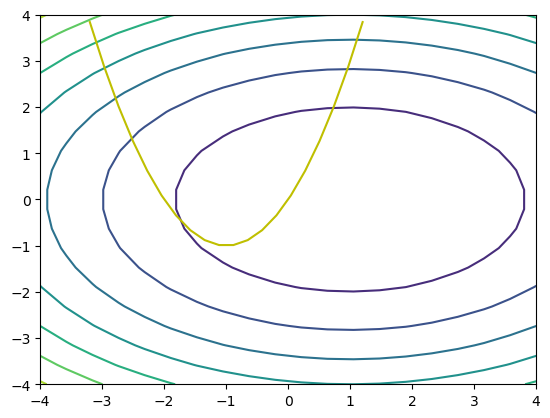

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7d74667dd090>

In [12]:
function plot_landscape()
    Nsamp = 20
    Xsamp = kron(ones(Nsamp),LinRange(-4,4,Nsamp)')
    Ysamp = kron(ones(Nsamp)',LinRange(-4,4,Nsamp))
    Zsamp = zeros(Nsamp,Nsamp)
    for j = 1:Nsamp
        for k = 1:Nsamp
            Zsamp[j,k] = f([Xsamp[j,k]; Ysamp[j,k]])
        end
    end
    contour(Xsamp,Ysamp,Zsamp)

    xc = LinRange(-3.2,1.2,Nsamp)
    plot(xc,xc.^2+2.0.*xc,"y")
end
plot_landscape()

In [6]:
function gauss_newton_step(x,λ)
    H = ∇2f(x)
    C = ∂c(x)
    Δz = [H C'; C 0]\[-∇f(x)-C'*λ; -c(x)]
    Δx = Δz[1:2]
    Δλ = Δz[3]
    return Δx, Δλ
end

gauss_newton_step (generic function with 1 method)

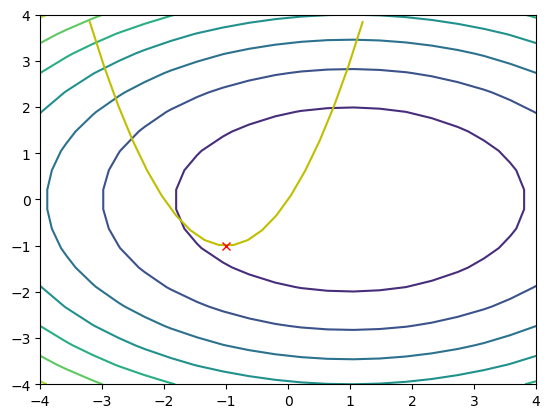

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7d746d59a590>

In [44]:
xguess = [-1; -1]
λguess = [0.0]
plot_landscape()
plot(xguess[1], xguess[2], "rx")

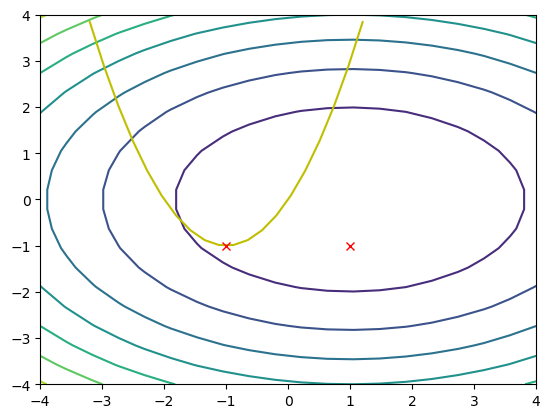

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7d7466cd7610>

In [9]:
Δx, Δλ = gauss_newton_step(xguess[:,end],λguess[end])
xguess = [xguess xguess[:,end]+Δx]
λguess = [λguess λguess[end]+Δλ]
plot_landscape()
plot(xguess[1,:], xguess[2,:], "rx")

In [31]:
function P(x,λ)
    ∇L = [-∇f(x)-∂c(x)'*λ; -c(x)]
    return 0.5*dot(∇L,∇L)
end
function ∇P(x,λ)
    H = ∇2f(x) + ForwardDiff.jacobian(xn -> ∂c(xn)'*λ, x)
    C = ∂c(x)
    return [H C'; C 0]*[-∇f(x)-C'*λ; -c(x)]
end

∇P (generic function with 1 method)

In [43]:
ρ = 10.0
function P(x,λ)
    f(x) + ρ*norm(c(x),1)
end
function ∇P(x,λ)
    [∇f(x) + ρ*∂c(x)'*sign.(c(x)); zeros(length(λ))]
end

∇P (generic function with 1 method)

In [27]:
ρ = 1.0
function P(x,λ)
    f(x) + λ'*c(x) + 0.5*ρ*dot(c(x),c(x))
end
function ∇P(x,λ)
    [∇f(x) + ∂c(x)'*(λ + ρ*c(x)); c(x)]
end

∇P (generic function with 1 method)

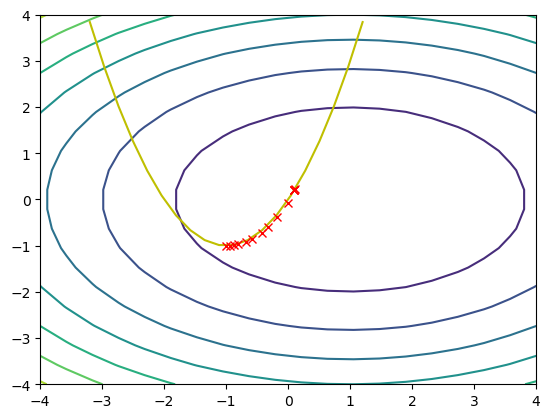

1

In [57]:
Δx, Δλ = gauss_newton_step(xguess[:,end],λguess[end])
α = 1
while P(xguess[:,end]+α*Δx, λguess[end]+α*Δλ) > P(xguess[:,end], λguess[end]) + 0.01*α*dot(∇P(xguess[:,end], λguess[end]),[Δx; Δλ])
    α = 0.5*α
end
xguess = [xguess xguess[:,end]+α*Δx]
λguess = [λguess λguess[end]+α*Δλ]
plot_landscape()
plot(xguess[1,:], xguess[2,:], "rx")
α